<a href="https://colab.research.google.com/github/Zhiyuan-03/AI_in_Transportation_Exercise/blob/main/SPEED%2BMLE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize

In [ ]:
# 1. Load data
from google.colab import files
import pandas as pd
from sklearn.model_selection import train_test_split
# Step 1: Upload the file (you already did this once, but keep for completeness)
uploaded = files.upload()

# Step 2: Load the uploaded CSV file
# Replace 'cf_pair25_v1.csv' with the exact filename you uploaded
data = pd.read_csv('cf_pair25_v1.csv')

In [2]:
data["Vehicle_ID_f"].unique()
vehicle_ids = data["Vehicle_ID_f"].unique()
N = len(vehicle_ids)
vehicle_ids_eval=data["Vehicle_ID_f"].unique()[-5:]
vehicle_ids_crossval=data["Vehicle_ID_f"].unique()[:-5]
N_eval=len(vehicle_ids_eval)
N_crossval=len(vehicle_ids_crossval)
print([int(x) for x in vehicle_ids_eval])  #should be 12638, 10 , 9683, 3054, 5167

[12638, 10, 9683, 3054, 5167]


In [6]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize

# Load data
df = pd.read_csv('cf_pair25_v1.csv')

# IDM model
def idm_model(s, v, delta_v, params, T=1.5, v0=30, s0=1):
    a, b = params
    delta = 4
    s_star = s0 + v * T + (v * delta_v) / (2 * np.sqrt(a * b))
    acceleration = a * (1 - (v / v0) ** delta - (s_star / s) ** 2)
    return acceleration

# Log-likelihood function
def log_likelihood(params, df, time_step=0.1, sigma=1.0):
    total_ll = 0
    grouped = df.groupby('Vehicle_ID_f')

    for vehicle_id, data in grouped:
        v_f = data['v_f'].iloc[0]
        x_f = data['x_f'].iloc[0]
        v_l = data['v_l'].values
        x_l = data['x_l'].values
        v_obs = data['v_f'].values

        v_sim = [v_f]
        x_sim = [x_f]

        for i in range(1, len(data)):
            s = x_l[i] - x_sim[-1] - data['length_l'].iloc[i]
            delta_v = v_sim[-1] - v_l[i]
            acc = idm_model(s, v_sim[-1], delta_v, params)
            new_v = v_sim[-1] + acc * time_step
            new_x = x_sim[-1] + new_v * time_step
            v_sim.append(new_v)
            x_sim.append(new_x)

        # Gaussian log-likelihood
        residuals = v_obs - np.array(v_sim)
        ll = -0.5 * np.sum((residuals / sigma) ** 2 + np.log(2 * np.pi * sigma**2))
        total_ll += ll

    return -total_ll  # Negative log-likelihood for minimization

# Initial guess and bounds
initial_guess = [1.0, 2.0]
bounds = [(0.1, 5.0), (0.1, 5.0)]

# Cross-validation
trajectories = {}
speed_curves = {}
all_params = []

vehicle_ids = df["Vehicle_ID_f"].unique()
N = len(vehicle_ids)
N_crossval = N - 5  # leave last 5 for evaluation

for start in range(0, N_crossval, 5):
    test_ids = vehicle_ids[start:start+5]
    train_ids = np.setdiff1d(vehicle_ids, test_ids)
    print("Test IDs:", test_ids)

    train_df = df[df["Vehicle_ID_f"].isin(train_ids)]
    test_df  = df[df["Vehicle_ID_f"].isin(test_ids)]

    # 1. Calibration (MLE on training set)
    result = minimize(log_likelihood, initial_guess, args=(train_df,), bounds=bounds, method='L-BFGS-B')
    params = result.x
    print("Calibrated params:", params)
    all_params.append(params)

    # 2. Testing (evaluate likelihood on test set)
    test_ll = log_likelihood(params, test_df)
    print("Test log-likelihood:", -test_ll)

    # You could also store trajectories/speed curves if you extend log_likelihood to return them

# Mean parameters across folds
mean_params = np.mean(np.array(all_params), axis=0)
print("Mean calibrated params:", mean_params)


Test IDs: [1939. 2740. 2933. 4189.   26.]
Calibrated params: [0.74971843 1.52193729]
Test log-likelihood: -3178.0381357800616
Test IDs: [ 2856.    15. 12043.  8809. 12166.]
Calibrated params: [0.70058348 1.97962573]
Test log-likelihood: -3114.2455749586998
Test IDs: [9.0000e+00 4.0940e+03 1.0768e+04 1.3420e+03 6.5340e+03]
Calibrated params: [0.65734931 1.55126312]
Test log-likelihood: -3323.9502463456206
Test IDs: [ 2259.  4330.  3817.  5763. 10069.]
Calibrated params: [0.70718849 1.94681586]
Test log-likelihood: -3659.931798874087
Mean calibrated params: [0.70370993 1.7499105 ]


In [18]:
def validate_idm_with_plots(df, params, time_step=0.1, sigma=1.0):

    grouped = df.groupby("Vehicle_ID_f")
    LL_list = []

    for vehicle_id, data in grouped:

        # observed
        v_obs = data["v_f"].values
        x_obs = data["x_f"].values
        a_obs = data["a_f"].values

        v_l = data["v_l"].values
        x_l = data["x_l"].values

        # initial values
        v_sim = [v_obs[0]]
        x_sim = [x_obs[0]]
        a_sim = [a_obs[0]]
        s_sim = [x_l[0] - x_obs[0] - data["length_l"].iloc[0]]

        # simulate
        for i in range(1, len(data)):
            s = x_l[i] - x_sim[-1] - data["length_l"].iloc[i]
            delta_v = v_sim[-1] - v_l[i]

            acc = idm_model(s, v_sim[-1], delta_v, params)

            v_next = v_sim[-1] + acc*time_step
            x_next = x_sim[-1] + v_next*time_step

            v_sim.append(v_next)
            x_sim.append(x_next)
            a_sim.append(acc)
            s_sim.append(s)

        v_sim = np.array(v_sim)
        x_sim = np.array(x_sim)
        a_sim = np.array(a_sim)
        s_sim = np.array(s_sim)

        t = np.arange(len(data))*time_step

        # PLOTS
        plt.figure(figsize=(10,5))
        plt.plot(t, v_l, label="Leader speed")
        plt.plot(t, v_obs, label="Observed v_f")
        plt.plot(t, v_sim, "--", label="Predicted v_f")
        plt.title(f"Vehicle {vehicle_id} – Speed")
        plt.legend()
        plt.show()

        plt.figure(figsize=(10,5))
        plt.plot(t, x_l, label="Leader x")
        plt.plot(t, x_obs, label="Observed x_f")
        plt.plot(t, x_sim, "--", label="Predicted x_f")
        plt.title(f"Vehicle {vehicle_id} – Position")
        plt.legend()
        plt.show()

        plt.figure(figsize=(10,5))
        plt.plot(t, a_obs, label="Observed acc")
        plt.plot(t, a_sim, "--", label="Predicted acc")
        plt.title(f"Vehicle {vehicle_id} – Acceleration")
        plt.legend()
        plt.show()

        plt.figure(figsize=(10,5))
        plt.plot(t, x_l - x_obs - data["length_l"].values, label="Observed spacing")
        plt.plot(t, s_sim, "--", label="Predicted spacing")
        plt.title(f"Vehicle {vehicle_id} – Spacing")
        plt.legend()
        plt.show()

        # LL (MLE-consistent)
        LL = np.sum(norm.logpdf(a_obs, loc=a_sim, scale=sigma))
        LL_list.append(LL)

    return {
        "Mean_LL": np.mean(LL_list),
        "Total_LL": np.sum(LL_list)
    }


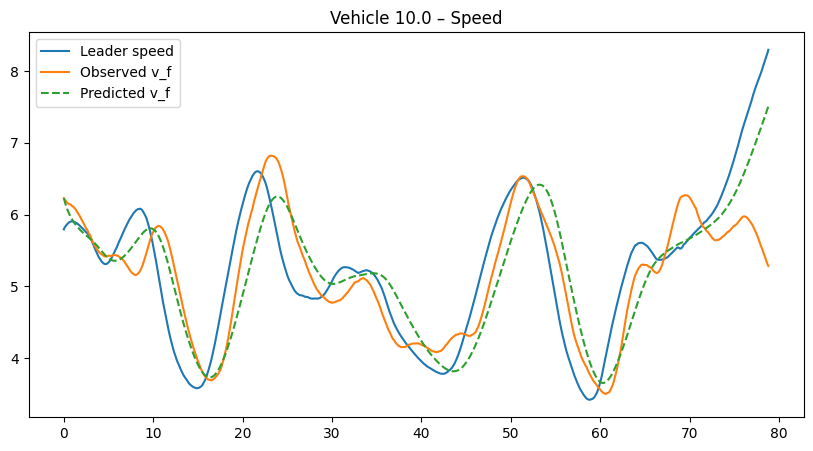

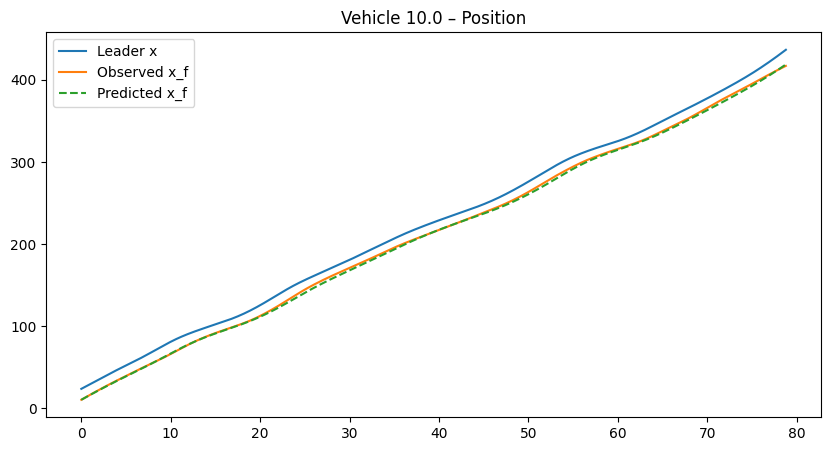

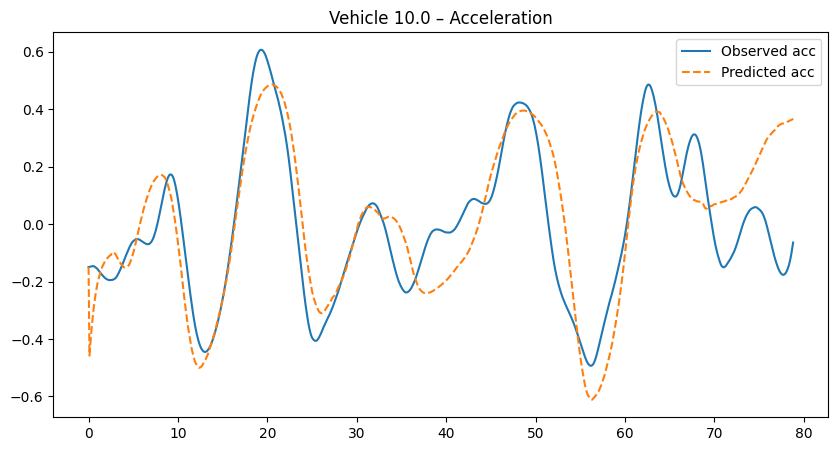

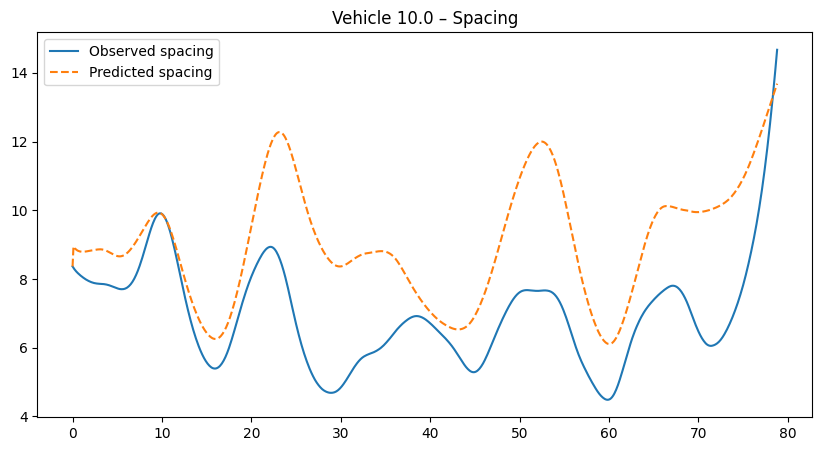

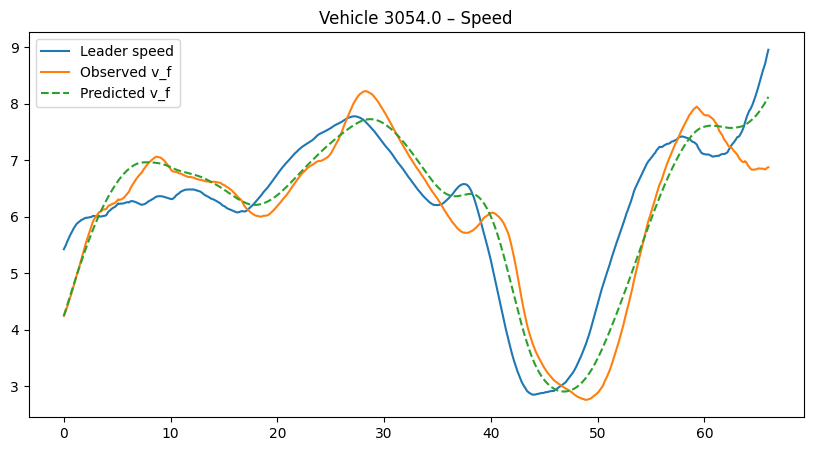

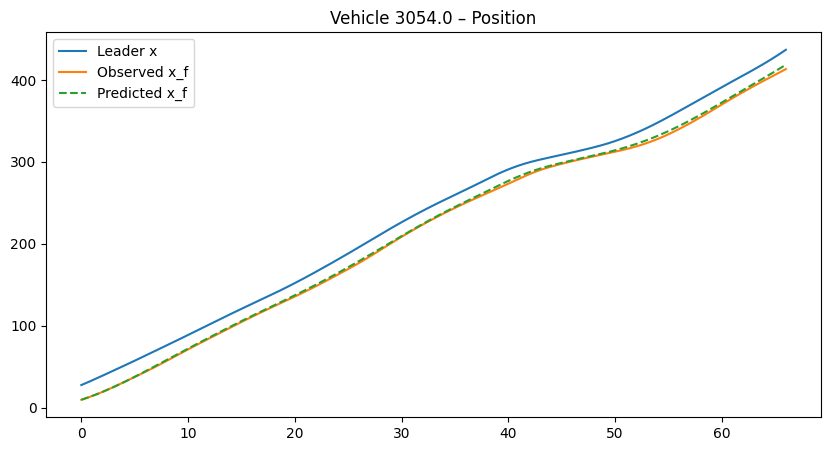

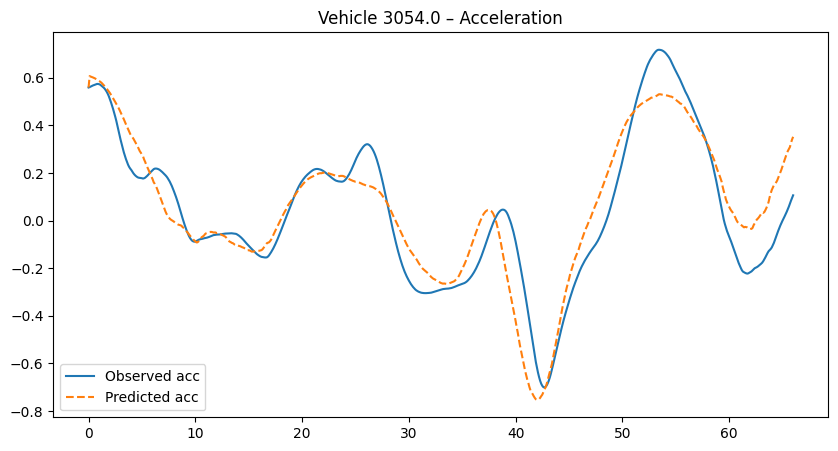

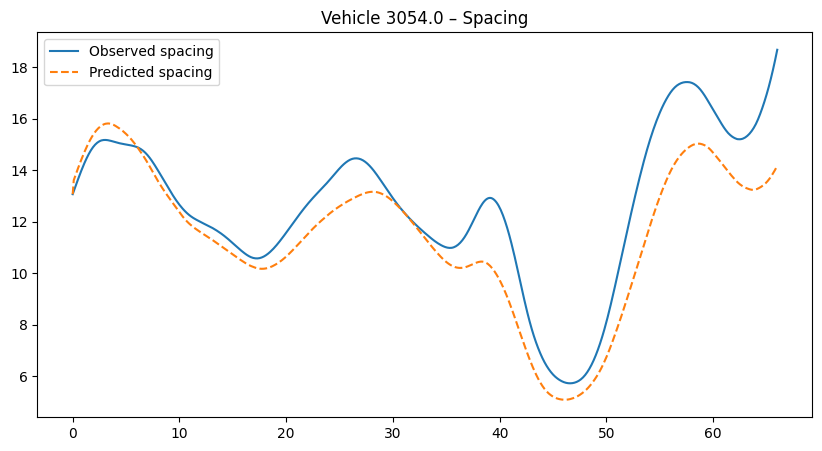

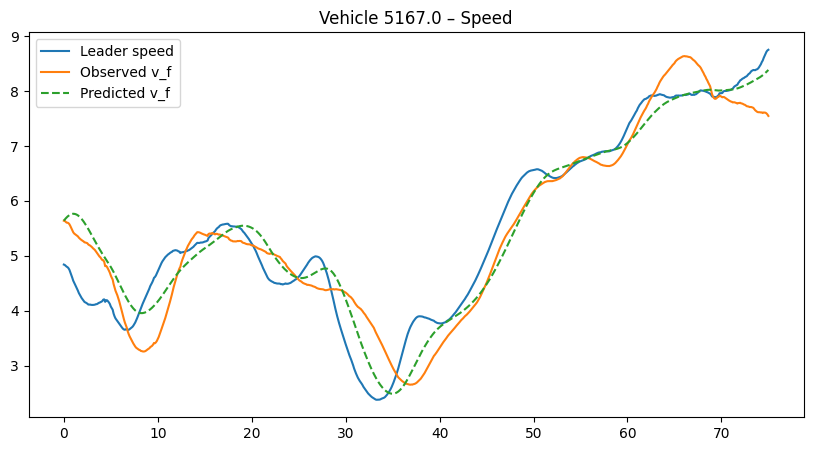

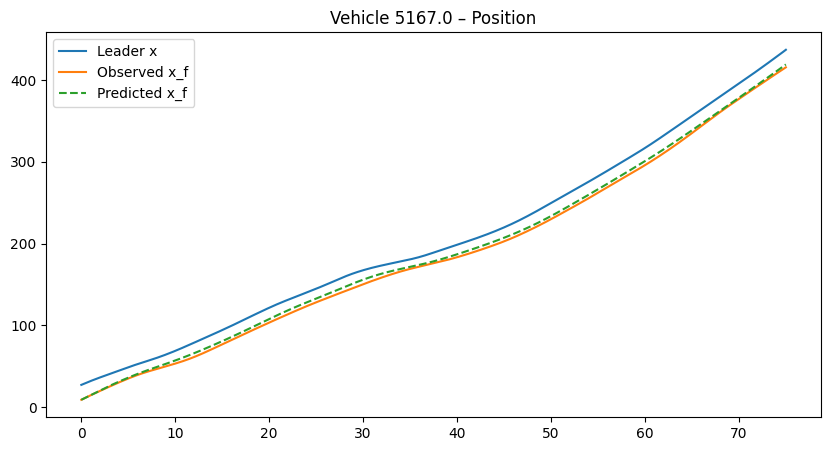

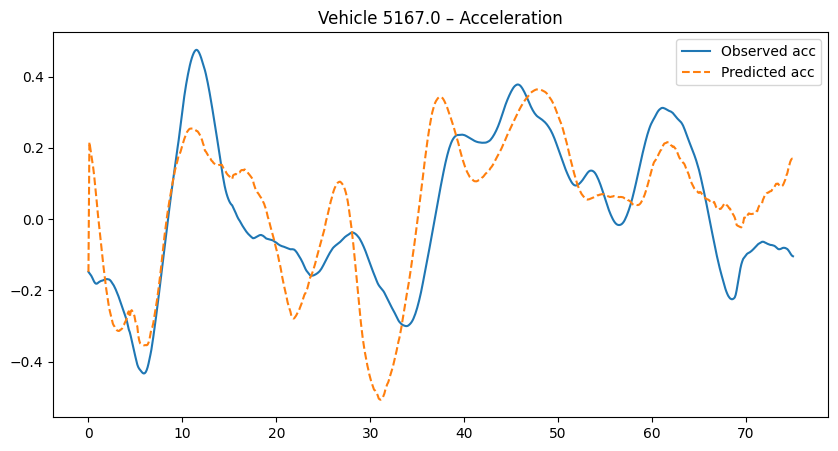

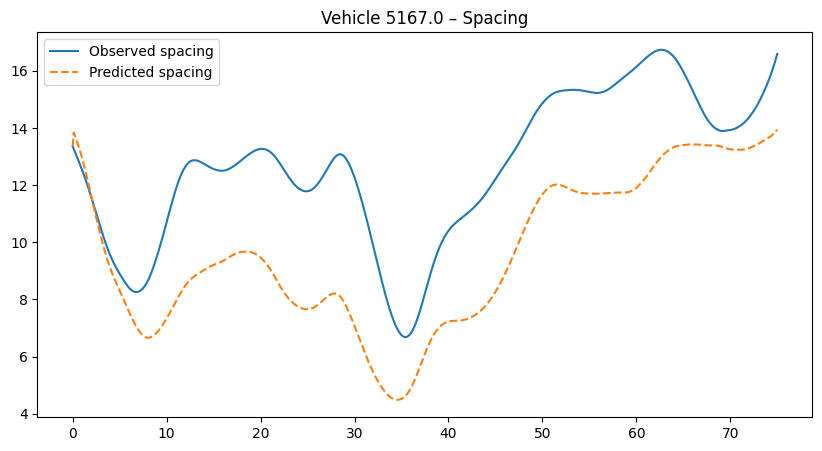

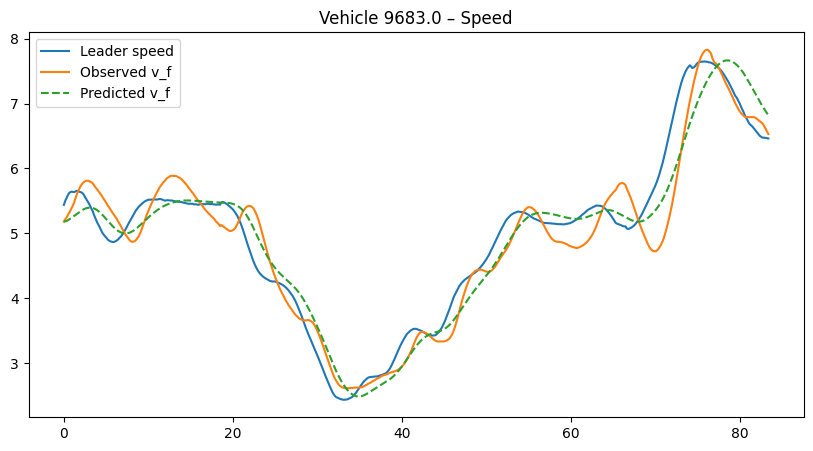

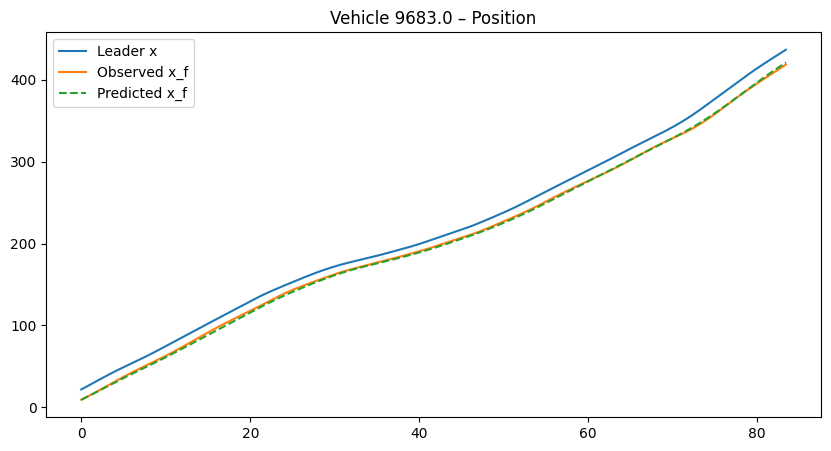

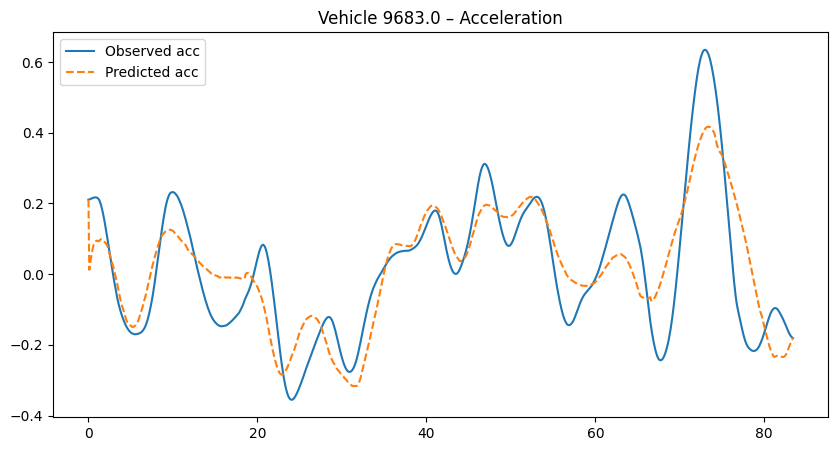

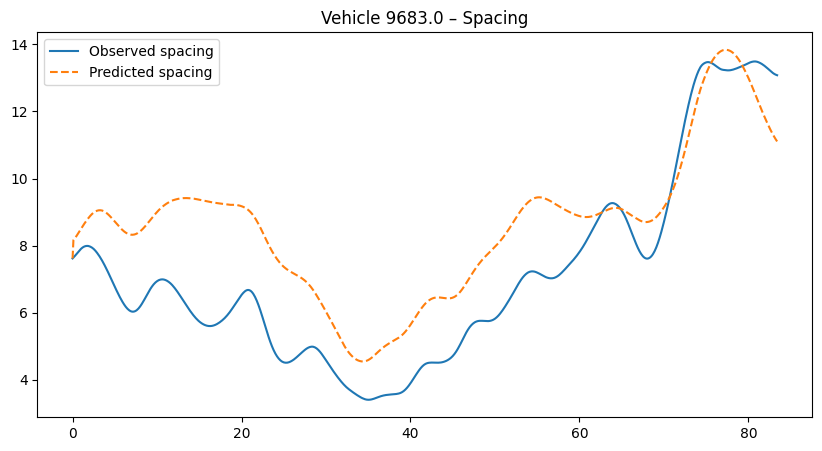

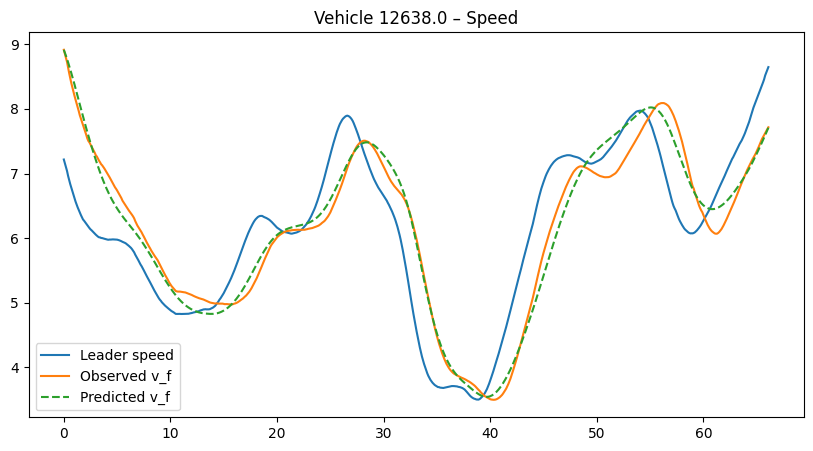

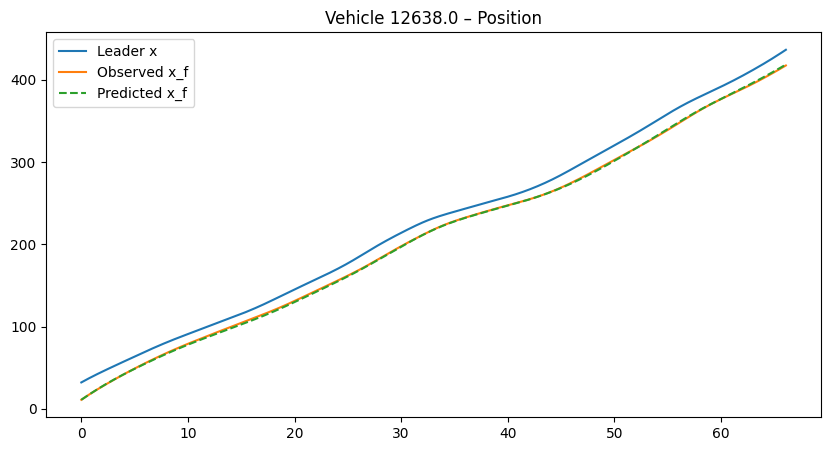

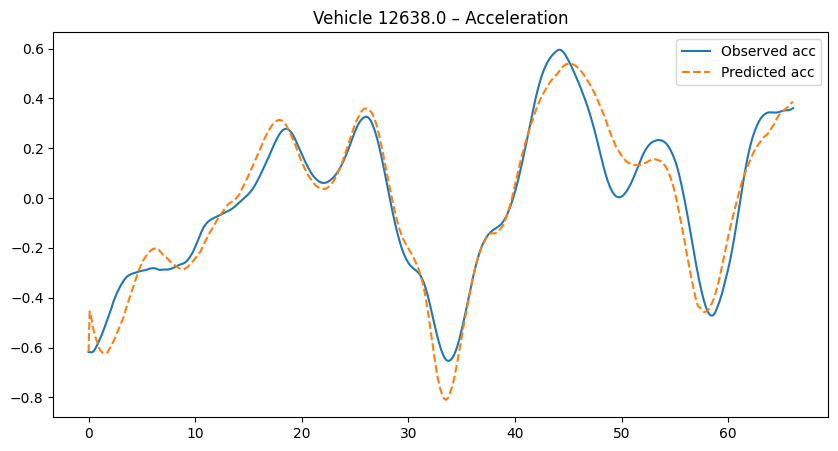

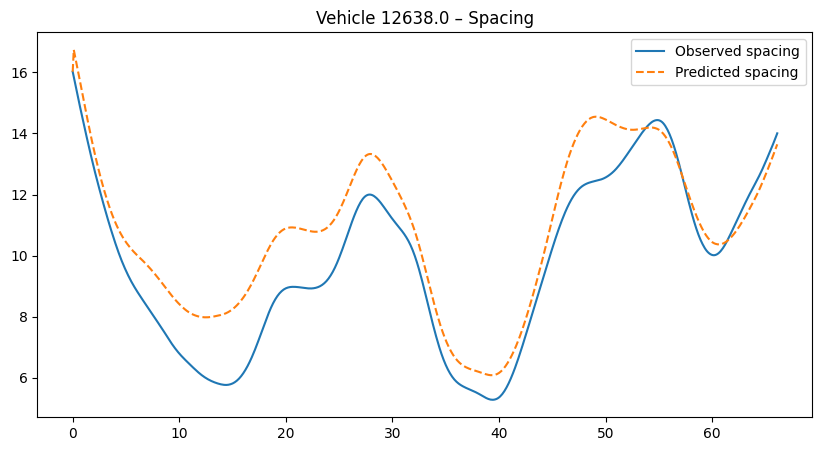

{'Mean_LL': np.float64(-685.6214083279075), 'Total_LL': np.float64(-3428.1070416395373)}


In [19]:
eval_df = df[df["Vehicle_ID_f"].isin(vehicle_ids[-5:])]   # last 5 vehicles
eval_results = validate_idm_with_plots(eval_df, mean_params)
print(eval_results)
